In [19]:
#@title GitHub Token Ekle

import ipywidgets as widgets
from IPython.display import display
import os

def github_token_button_clicked(b):
    os.environ["GITHUB_TOKEN"] = "REMOVED_TOKEN"
    print("GitHub Token ortam değişkenine eklendi!")

button1 = widgets.Button(
    description="GitHub Token Ekle",
    button_style='',
    tooltip='GitHub Token Ortam Değişkenine Ekle'
)
button1.on_click(github_token_button_clicked)
display(button1)


Button(description='GitHub Token Ekle', style=ButtonStyle(), tooltip='GitHub Token Ortam Değişkenine Ekle')

GitHub Token ortam değişkenine eklendi!


In [20]:
#@title GitHub Token Ekle

import ipywidgets as widgets
import os
import datetime
from google.colab import drive
from IPython.display import display

def sync_drive_github(b):
    # Google Drive'ı bağla
    drive.mount('/content/drive', force_remount=True)

    # Git kullanıcı bilgilerini ayarla
    os.system('git config --global user.email "doganzub@gmail.com" > /dev/null 2>&1')
    os.system('git config --global user.name "doganzub" > /dev/null 2>&1')

    # GitHub Token kontrolü
    GITHUB_TOKEN = os.environ.get("GITHUB_TOKEN")
    if not GITHUB_TOKEN:
        print("❌ HATA: GitHub Token bulunamadı! Lütfen önce Buton 1 ile ayarlayın.")
        return

    # GitHub repo bağlantısı
    GITHUB_REPO = f"https://{GITHUB_TOKEN}@github.com/doganzub/ml.git"

    # Çalıştırılan notebook'un yolu ve adı (manuel düzenleyin)
    notebook_path = "/content/drive/MyDrive/Colab Notebooks/"
    running_notebook = "1_veri_gorsellestirme.ipynb"

    # Repo yoksa klonla
    if not os.path.exists("/content/ml"):
        os.system(f"cd /content && git clone {GITHUB_REPO}")

    # Git dizinine geç
    os.chdir("/content/ml")

    # Branch listesini al
    os.system("git fetch --all")
    existing_branches = os.popen("git branch -r").read()

    filename_parts = running_notebook.split("_")
    if not filename_parts[0].isdigit():
        print(f"🚫 {running_notebook} dosyasının başında rakam yok, işlem iptal edildi!")
    else:
        ders_no = filename_parts[0]
        branch_name = f"ders{ders_no}"

        if f"origin/{branch_name}" not in existing_branches:
            print(f"🚫 {branch_name} branch'i GitHub'da bulunamadı, işlem iptal edildi!")
        else:
            os.system(f"git checkout {branch_name}")
            os.system(f'cp "{notebook_path}{running_notebook}" "/content/ml/"')
            commit_message = f"{running_notebook} güncellendi - {datetime.datetime.now().strftime('%Y-%m-%d %H:%M')}"
            os.system("git add .")
            status = os.popen("git status --porcelain").read()

            if status.strip():
                os.system(f'git commit -m "{commit_message}"')
                os.system(f"git push origin {branch_name}")
                print(f"✅ {running_notebook} {branch_name} branch'ine yüklendi!")
            else:
                print(f"⚡ {running_notebook} için değişiklik yok, commit atlanıyor!")
            os.system(f'cp -f "/content/ml/{running_notebook}" "{notebook_path}"')

    print("🎯 GitHub ve Google Drive senkronize edildi!")

# Buton 2: Drive & GitHub Senkronizasyonu
button2 = widgets.Button(
    description="Drive & GitHub Senkronizasyonu",
    button_style='',
    tooltip='Google Drive ve GitHub arasında senkronizasyon yap'
)
button2.on_click(sync_drive_github)
display(button2)

Button(description='Drive & GitHub Senkronizasyonu', style=ButtonStyle(), tooltip='Google Drive ve GitHub aras…

Mounted at /content/drive
✅ 1_veri_gorsellestirme.ipynb ders1 branch'ine yüklendi!
🎯 GitHub ve Google Drive senkronize edildi!


# **1.Python ile Veri Görselleştirme**

Bu derste, Python kullanarak veri görselleştirme tekniklerini uygulamalı olarak öğreneceğiz. Özellikle sigorta veri seti (insurance.csv) üzerinden
veri setinin yüklenmesi, sütun isimlerinin Türkçeleştirilmesi, veri tiplerinin düzenlenmesi ve çeşitli grafiklerin (çizgi, bar, scatter, histogram, box, pasta, scatter matrix) oluşturulması adımlarını inceleyeceğiz.


## 1.1 **Google Drive Bağlantısı ve Kütüphane Yükleme**

**Açıklama (Mark):**  
- Google Drive’daki veri setlerine erişebilmek için Drive’ı bağlamamız gerekir (Colab kullanıyorsanız).  
- Gerekli Python kütüphaneleri yüklenip içe aktarılır.  
- Bu kod bloğu, temel kütüphanelerin kurulumunu ve içe aktarılmasını gösterir.  

### 🔹 Kullanılan Kütüphaneler ve Açıklamaları:
- **`numpy`** → Sayısal hesaplamalar ve matris işlemleri için kullanılır.
- **`pandas`** → Veri işleme, analiz ve veri çerçeveleri ile çalışma imkanı sunar.
- **`matplotlib`** → Grafik ve veri görselleştirme için temel kütüphanelerden biridir.
- **`seaborn`** → Daha gelişmiş ve estetik veri görselleştirme için matplotlib'in üzerine inşa edilmiştir.
**`sklearn`**  (scikit-learn) → Veri ön işleme, modelleme ve değerlendirme araçları içerir.
- **`yellowbrick`** → Makine öğrenmesi modellerinin görselleştirilmesini sağlayan bir kütüphane.

✅ **Bu kütüphaneler, veri analizi ve modelleme süreçlerinde sıkça kullanılır.**


In [1]:
# Gerekli kütüphanelerin yüklenmesi
!pip install -q numpy pandas scikit-learn matplotlib seaborn yellowbrick

# Kütüphanelerin içeri aktarılması
import numpy as np                # Sayısal hesaplamalar ve diziler için
import pandas as pd               # Veri çerçeveleri ile çalışmak için
import matplotlib.pyplot as plt   # Grafik çizimi için
import seaborn as sns             # Gelişmiş veri görselleştirme için

# Ek modüller ve sklearn fonksiyonları
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.cluster import KMeans
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (mean_squared_error, mean_absolute_error,
                             accuracy_score, classification_report,
                             confusion_matrix, ConfusionMatrixDisplay,
                             silhouette_score)
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn import datasets     # Veri ön işleme, modelleme ve değerlendirme araçları


from google.colab import drive
drive.mount('/content/drive')       #Google Drive’a bağlanmamızı sağlar (Colab).

Mounted at /content/drive


## **1.2 Sigorta Veri Setinin Yüklenmesi ve Temel İşlemler**

- Google Drive’da bulunan `insurance.csv` dosyası okunacaktır.
- Veri setinin sütun isimleri İngilizce’den Türkçe’ye çevrilecek (ör. `age` → `yas`, `sex` → `cinsiyet`, vb.).
- Kategorik sütunların veri tipi `category` olarak ayarlanacak.
- Kategorik değerler güncellenecek (örneğin, "male" → "erkek").
- Son olarak, veri setinin özet istatistikleri alınarak veri yapısı kontrol edilecektir.

## **1.2.1 Veri Setini Okuma**

In [2]:
# Veri setini Google Drive'dan okuyoruz
# Pandas DataFrame formatına çeviriyoruz
# ve 'insurance_df' isimli değişkene atıyoruz
insurance_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/insurance.csv')

# 'dtypes' Her sutunun veri tipini gösterir
print(insurance_df.dtypes)


# İlk 5 satırı görüntüleyerek veri setine göz atalım
display(insurance_df.head())

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## **1.2.2 Sütun İsimlerini Türkçeleştirme**

In [3]:
# İngilizce sütun isimlerini Türkçeye çeviriyoruz
# DataFrame.rename(columns={...}): Sütun adlarını değiştirmemizi sağlar.

insurance_df = insurance_df.rename(columns={
    "age": "yas",
    "sex": "cinsiyet",
    "bmi": "vki",
    "children": "cocukSayisi",
    "smoker": "sigaraDurum",
    "region": "bolge",
    "charges": "odemeMiktari"
})

# Değişiklikleri doğrulamak için ilk 5 satırı tekrar gözlemleyelim
insurance_df.head()


,yas,cinsiyet,vki,cocukSayisi,sigaraDurum,bolge,odemeMiktari
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## **1.2.3 `object` Kategorik Sütunları --> `category` Veri Tipine Dönüştürme**

## Neden `"category"` Veri Tipine Dönüştürüyoruz?

### 1️⃣ Bellek Kullanımını Azaltır  
- **`object` veri tipi**, her hücre için ayrı ayrı metin (string) saklar ve fazla yer kaplar.  
- **`category` tipi**, tekrar eden değerleri hafızada tek bir kez saklayarak **daha az bellek kullanır**.

### 2️⃣ İşlem Verimliliğini Artırır
- Makine öğrenmesi ve veri analizi işlemlerinde kategorik değişkenler genellikle **nümerik olarak işlenir**.  
- **`category` veri tipi**, işlemleri hızlandırır çünkü **daha hızlı karşılaştırma ve gruplama yapabilir**.

### 3️⃣ Veri Analizini Kolaylaştırır  
- Kategorik değişkenlerin **sınıflarını** (`.cat.categories`) ve **frekanslarını** (`.value_counts()`) daha kolay analiz edebilirsin.  


### **ilk Veri Tipleri** Kontrol Etme

In [4]:
# Sütunların ilk veri tiplerini Kontrol etme
print("İlk veri tipleri:")

#DataFrame.dtypes: Her sütunun veri tipini (int, float, object vs.) gösterir.
print(insurance_df.dtypes)

İlk veri tipleri:
yas               int64
cinsiyet         object
vki             float64
cocukSayisi       int64
sigaraDurum      object
bolge            object
odemeMiktari    float64
dtype: object


### **Dönüştürme İşlemi ve Sonrası Veri Tipleri** Kontrol Etme

In [5]:
# `astype('category')`: Nesnel (object) tipindeki sütunları kategorik tipine çevirerek
# bellek kullanımını ve işlem verimliliğini artırır.

insurance_df["cinsiyet"] = insurance_df["cinsiyet"].astype("category")
insurance_df["sigaraDurum"] = insurance_df["sigaraDurum"].astype("category")
insurance_df["bolge"] = insurance_df["bolge"].astype("category")

# Dönüşüm sonrası veri tiplerini kontrol etmek için:
print("\nDönüştürme sonrası veri tipleri:")
print(insurance_df.dtypes)



Dönüştürme sonrası veri tipleri:
yas                int64
cinsiyet        category
vki              float64
cocukSayisi        int64
sigaraDurum     category
bolge           category
odemeMiktari     float64
dtype: object


## **1.2.4 Kategorik Değerleri Güncelleme (İngilizce → Türkçe)**
- `replace([...], [...])`: Belirli değerleri yenileriyle eşleştirip dönüştürür.


In [6]:
# Örnek: 'male' -> 'erkek', 'female' -> 'kadin', vb.
insurance_df["cinsiyet"] = insurance_df["cinsiyet"].replace(["male", "female"], ["erkek", "kadin"])
insurance_df["sigaraDurum"] = insurance_df["sigaraDurum"].replace(["no", "yes"], ["hayir", "evet"])
insurance_df["bolge"] = insurance_df["bolge"].replace(
    ["southeast", "northwest", "southwest", "northeast"],
    ["guneydogu", "kuzeybati", "guneybati", "kuzeydogu"]
)

# Değişiklikleri görmek için
insurance_df.head(10)

<ipython-input-6-7c7bac764cad>:2: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  insurance_df["cinsiyet"] = insurance_df["cinsiyet"].replace(["male", "female"], ["erkek", "kadin"])
<ipython-input-6-7c7bac764cad>:3: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  insurance_df["sigaraDurum"] = insurance_df["sigaraDurum"].replace(["no", "yes"], ["hayir", "evet"])
<ipython-input-6-7c7bac764cad>:4: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserv

,yas,cinsiyet,vki,cocukSayisi,sigaraDurum,bolge,odemeMiktari
0,19,kadin,27.900,0,evet,guneybati,16884.92400
1,18,erkek,33.770,1,hayir,guneydogu,1725.55230
2,28,erkek,33.000,3,hayir,guneydogu,4449.46200
3,33,erkek,22.705,0,hayir,kuzeybati,21984.47061
4,32,erkek,28.880,0,hayir,kuzeybati,3866.85520
5,31,kadin,25.740,0,hayir,guneydogu,3756.62160
6,46,kadin,33.440,1,hayir,guneydogu,8240.58960
7,37,kadin,27.740,3,hayir,kuzeybati,7281.50560
8,37,erkek,29.830,2,hayir,kuzeydogu,6406.41070
9,60,kadin,25.840,0,hayir,kuzeybati,28923.13692


## **1.3 Veri Setinin Özet İstatistikleri**

In [7]:
print("\nSayısal özet (describe):")

# describe(): Sayısal sütunlar için istatistiksel özet (ortalama, std, min, max vb.) verir.
print(insurance_df.describe())

pd.set_option("display.max_columns", 20)
print("\nTüm sütun özet bilgisi:")
# describe(include='all'): Kategorik sütunları da özetleyerek benzersiz değer sayısı,
# en sık görülen değer vb. bilgileri gösterir.
print(insurance_df.describe(include="all"))


Sayısal özet (describe):
               yas          vki  cocukSayisi  odemeMiktari
count  1338.000000  1338.000000  1338.000000   1338.000000
mean     39.207025    30.663397     1.094918  13270.422265
std      14.049960     6.098187     1.205493  12110.011237
min      18.000000    15.960000     0.000000   1121.873900
25%      27.000000    26.296250     0.000000   4740.287150
50%      39.000000    30.400000     1.000000   9382.033000
75%      51.000000    34.693750     2.000000  16639.912515
max      64.000000    53.130000     5.000000  63770.428010

Tüm sütun özet bilgisi:
                yas cinsiyet          vki  cocukSayisi sigaraDurum      bolge  \
count   1338.000000     1338  1338.000000  1338.000000        1338       1338   
unique          NaN        2          NaN          NaN           2          4   
top             NaN    erkek          NaN          NaN       hayir  guneydogu   
freq            NaN      676          NaN          NaN        1064        364   
mean      39.

## **1.3 Veri Setinin İstatistik Açıklamaları**

### 🔹 **Yaş Dağılımı:**
- **En genç birey:** 18 yaş  
- **En yaşlı birey:** 64 yaş  
- **Ortalama yaş:** 39.2  
- **Yaş dağılımındaki standart sapma:** 14.05  
  ➝ **Bireylerin büyük çoğunluğu (~%68) 25 ile 53 yaş arasındadır.**  

---

### 🔹 **Vücut Kitle İndeksi (VKİ):**
- **En düşük VKİ:** 15.96  
- **En yüksek VKİ:** 53.13  
- **Ortalama VKİ:** 30.66  
- **VKİ'nin standart sapması:** 6.09  
  ➝ **Bireylerin büyük çoğunluğu (~%68) 24.57 ile 36.75 VKİ aralığındadır.**  

---

### 🔹 **Çocuk Sahibi Olma Durumu:**
- **Maksimum çocuk sayısı:** 5  
- **Ortalama çocuk sayısı:** 1.09  
- **Çocuk sahibi olmayan bireylerin yüzdesi:** %50’den fazla  
  ➝ **Bireylerin çoğu ya çocuksuz ya da en fazla 1-2 çocuğa sahiptir.**  

---

### 🔹 **Sigara İçme Durumu:**
- **Sigara içmeyen birey sayısı:** 1064  
- **Sigara içen birey sayısı:** 274  
  ➝ **Bireylerin %79’u sigara içmiyor.**  

---

### 🔹 **Bölgesel Dağılım:**
- **En fazla birey bulunan bölge:** Güneydoğu (*guneydogu*) → **364 kişi**  
- **Diğer bölgeler:** Kuzeybatı (*kuzeybati*), Güneybatı (*guneybati*), Kuzeydoğu (*kuzeydogu*)  
  ➝ **Bireylerin en yoğun bulunduğu bölge Güneydoğu’dur.**  

---

### 🔹 **Sağlık Sigortası Ödeme Miktarları:**
- **En düşük ödeme:** **1,121.87$**  
- **En yüksek ödeme:** **63,770.42$**  
- **Ortalama ödeme:** **13,270.42$**  
- **Ödeme miktarlarının standart sapması:** **12,110.01$**  
  ➝ **Bireylerin büyük çoğunluğu (~%68) 1,160$ ile 25,380$ arasında ödeme yapmaktadır.**  


## **1.4 Veri Görselleştirme (Insurance)**

### **1.4.1 Çizgi Grafik (Line Plot)**

**Örnek 1:** İlk 20 müşterinin VKİ (Vücut Kitle İndeksi) değerlerini çizgi grafik ile görselleştirme.

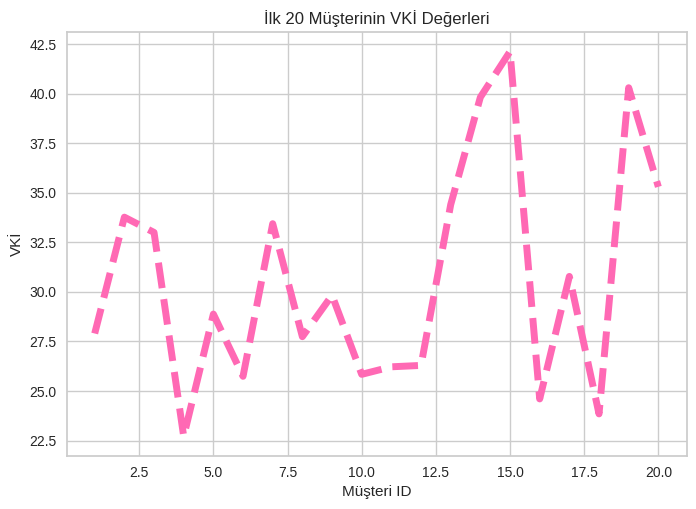

In [8]:
x_line = np.arange(1, 21)  # Müşteri ID’leri 1'den 20'ye
y_line = insurance_df.iloc[0:20, 2]  # İlk 20 müşterinin VKİ sütunu (index 2)

plt.figure()
plt.plot(x_line, y_line, linestyle="dashed", color="hotpink", linewidth=5)
plt.title("İlk 20 Müşterinin VKİ Değerleri")
plt.xlabel("Müşteri ID")
plt.ylabel("VKİ")
plt.show()


**Örnek 2:** 40-60 Müşterilerin Yaş Dağılımı

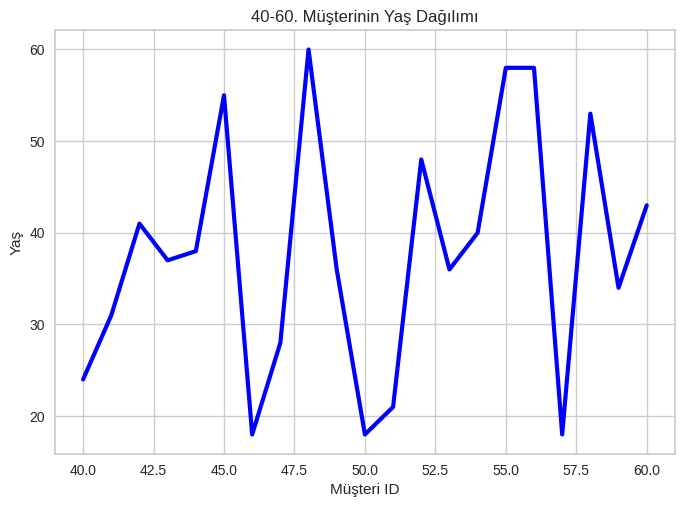

In [9]:
x_line = np.arange(40, 61)
y_line = insurance_df.iloc[40:61, 0]  # Dizi boyutunu eşitlemek için 40:61 kullanıldı

plt.figure()
plt.plot(x_line, y_line, color="blue", linewidth=3)
plt.title("40-60. Müşterinin Yaş Dağılımı")
plt.xlabel("Müşteri ID")
plt.ylabel("Yaş")

plt.show()

**Örnek 3:** İlk 20 ile 21-40 arasındaki müşterilerin VKİ değerlerinin karşılaştırılması.

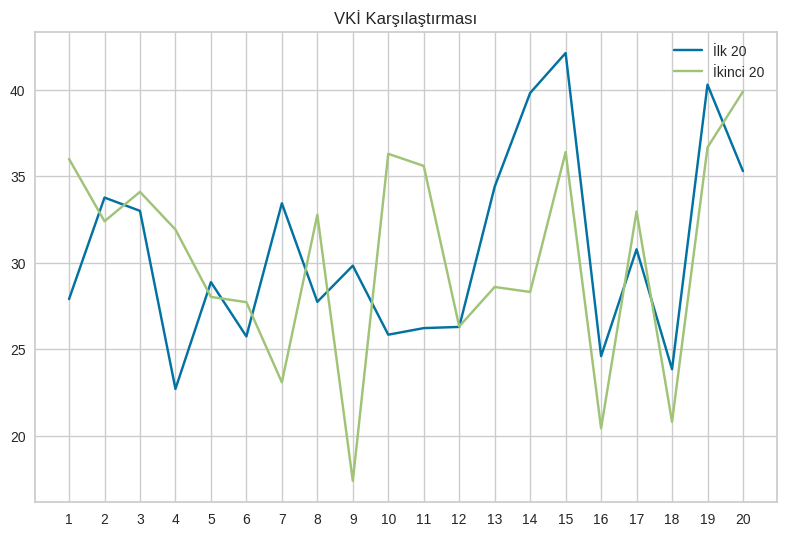

In [10]:
x_line2 = np.arange(1, 21)        # X ekseni için 1'den 20'ye kadar olan değerleri içeren bir NumPy dizisi oluşturuluyor
y1 = insurance_df.iloc[0:20, 2]   # İlk 20 müşterinin 2. sütundaki (VKİ gibi bir değer) verisini al
y2 = insurance_df.iloc[20:40, 2]  # Sonraki 20 müşterinin 2. sütundaki verisini al (21-40. satırlar)

plt.figure()                      # Yeni bir grafik figürü oluştur

plt.xticks(x_line2)               # X ekseninde 1'den 20'ye kadar olan tam sayıları göster
plt.plot(x_line2, y1, label="İlk 20")  # İlk 20 müşteri için çizgi grafiği oluştur
plt.plot(x_line2, y2, label="İkinci 20")  # İkinci 20 müşteri için çizgi grafiği oluştur

plt.title("VKİ Karşılaştırması")  # Grafiğe başlık ekle
plt.legend()                      # Çizgilerin hangi gruba ait olduğunu gösteren bir açıklama (legend) ekle
plt.tight_layout(pad=1)           # Grafik düzenini optimize ederek kenar boşluklarını ayarla
plt.show()                        # Grafiği ekrana bastır


**Örnek 4:** İlk 50 müşterinin yaş dağılımının çizgi grafiği.

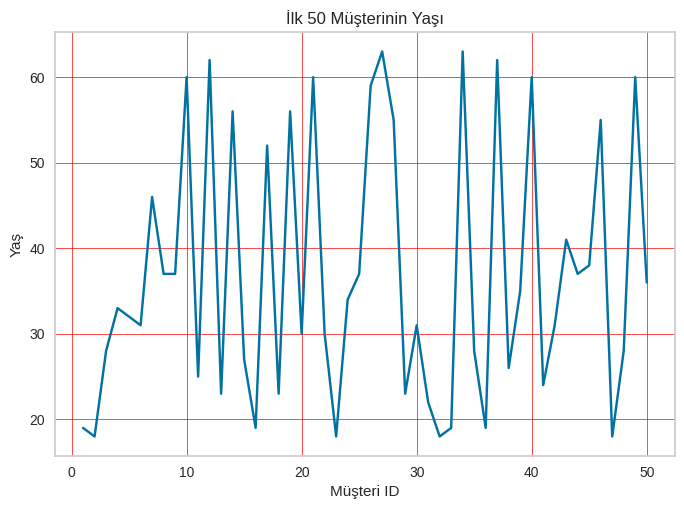

In [11]:
import numpy as np
import matplotlib.pyplot as plt

x_age = np.arange(1, 51)            # 1'den 50'ye kadar müşteri ID'lerini içeren NumPy dizisi oluştur
y_age = insurance_df.iloc[0:50, 0]  # İlk 50 müşterinin yaş bilgilerini içeren sütunu seç (0. sütun)

plt.figure()                        # Yeni bir grafik figürü oluştur
plt.title("İlk 50 Müşterinin Yaşı") # Grafiğe başlık ekle
plt.xlabel("Müşteri ID")            # X ekseni etiketi (Müşteri ID'leri)
plt.ylabel("Yaş")                   # Y ekseni etiketi (Müşterilerin yaşları)

plt.plot(x_age, y_age)              # Müşteri ID'lerine karşılık gelen yaşları çizgi grafiği olarak çiz
plt.grid(color="red", linestyle="solid", linewidth=0.5)  # Grafiğe kırmızı renkli ve ince bir ızgara çizgisi ekle

plt.show()


### **1.4.2 Bar Grafikleri**

**Örnek 1:** Sigara içme durumuna göre ortalama ödeme miktarının bar grafiği.

Index(['yas', 'cinsiyet', 'vki', 'cocukSayisi', 'sigaraDurum', 'bolge',
       'odemeMiktari'],
      dtype='object')


<ipython-input-12-c6496544d086>:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ozet = insurance_df.groupby("sigaraDurum")["odemeMiktari"].mean()


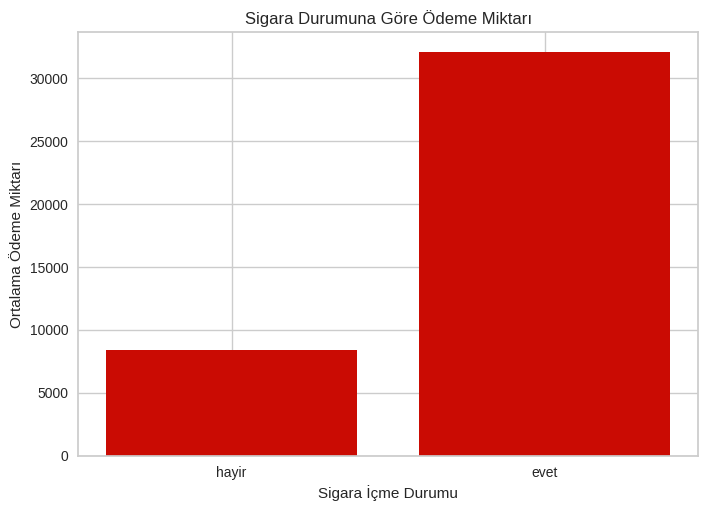

In [12]:
# Sigara içme durumuna göre ortalama ödeme miktarını hesapla
print(insurance_df.columns)
ozet = insurance_df.groupby("sigaraDurum")["odemeMiktari"].mean()
        # - 'groupby("sigaraDurum")' → Veriyi "sigara içme durumu" sütununa göre gruplar.
        # - '["odemeMiktari"].mean()' → Her grup için ödeme miktarının ortalamasını alır.

plt.figure()  # Yeni bir grafik figürü oluştur

plt.bar(x=ozet.index, height=ozet.values, color="r")
        # Dikey çubuk grafiği çiz
        # - 'x=ozet.index' → Çubukların kategorik değerleri (sigara içen/içmeyen).
        # - 'height=ozet.values' → Çubukların yüksekliği (ortalama ödeme miktarları).
        # - 'color="r"' → Çubukların rengi kırmızı ("r") olarak ayarlanır.

plt.xlabel("Sigara İçme Durumu")      # X ekseni etiketi (Sigara içme durumu)
plt.ylabel("Ortalama Ödeme Miktarı")  # Y ekseni etiketi (Ödeme miktarının ortalaması)
plt.title("Sigara Durumuna Göre Ödeme Miktarı")  # Grafiğe başlık ekle

plt.show()



**Örnek 2:** Yatay bar grafiği.

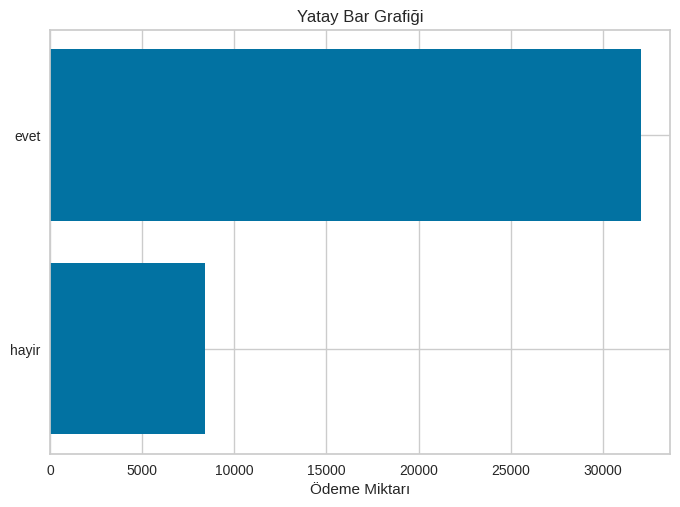

In [13]:
plt.figure()          # Yeni bir grafik figürü oluştur

#Yatay çubuk grafiği çiz
plt.barh(y=ozet.index, width=ozet.values, color="b")
      # - 'y=ozet.index' → Çubukların kategorik değerleri (sigara içme durumu gibi).
      # - 'width=ozet.values' → Çubukların uzunluğu (ödeme miktarları).
      # - 'color="b"' → Çubukların rengi mavi ("b") olarak ayarlanır.

plt.xlabel("Ödeme Miktarı")     # X eksenine etiket ekle (Ödeme miktarlarını gösterir)
plt.title("Yatay Bar Grafiği")  # Grafiğe başlık ekle
plt.show()


### **1.4.3 Pasta Grafiği (Pie Chart)**

**Örnek:** Bölgeye göre toplam ödeme miktarını gösteren pasta grafiği.

<ipython-input-14-7b13eb3b8962>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ozet_bolge = insurance_df.groupby("bolge")["odemeMiktari"].sum()


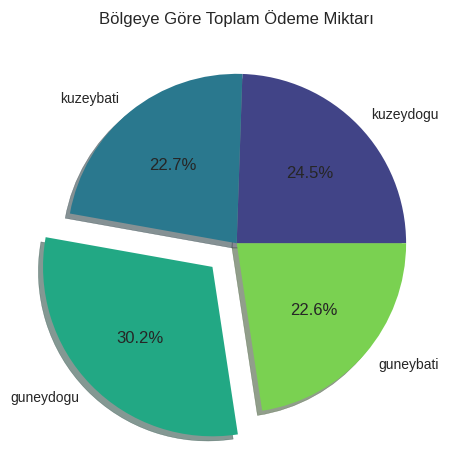

In [14]:
# "bolge" sütununa göre gruplandırarak her bölgedeki toplam ödeme miktarını hesapla
ozet_bolge = insurance_df.groupby("bolge")["odemeMiktari"].sum()
        # - 'groupby("bolge")' → Veriyi bölgelere göre gruplar.
        # - '["odemeMiktari"].sum()' → Her bölge için ödeme miktarlarının toplamını hesaplar.

etiketler = ozet_bolge.index  # Pasta grafiği için bölge isimlerini etiket olarak al
degerler = ozet_bolge.values  # Pasta dilimlerinin büyüklüğünü belirlemek için ödeme miktarlarını al
renkler = sns.color_palette("viridis", len(etiketler))  # Pasta grafiği için renk paleti oluştur (Her dilime farklı bir renk atar).
explode_vals = [0] * len(etiketler)                     # Başlangıçta tüm dilimleri patlatma (normal göster)


# Eğer en az 3 bölge varsa, üçüncü dilimi patlat (grafikte öne çıkarmak için)
if len(etiketler) >= 3:
    explode_vals[2] = 0.2  # 3. dilimi biraz dışarı çıkar

plt.figure()  # Yeni bir grafik figürü oluştur

plt.pie(
    degerler,               # Pasta dilimlerinin büyüklüğü
    explode=explode_vals,   # Hangi dilimler öne çıkarılacak (explode effect)
    labels=etiketler,       # Dilimlerin etiketleri (Bölge isimleri)
    autopct="%4.1f%%",      # Dilimlerin yüzdesini göster (4.1f → %4.1 formatında göster)
    shadow=True,            # Gölgeli efekt ekle (grafiği daha okunaklı yapar)
    startangle=360,         # Grafiği 360 dereceden başlat (dilimlerin konumunu belirler)
    colors=renkler          # Dilimler için renk paletini uygula
)

plt.title("Bölgeye Göre Toplam Ödeme Miktarı")  # Grafiğe başlık ekle
plt.show()


### **1.4.4 Serpilme/Dağılım Plot (Scatter Plot)**

**Örnek 1:** Yaş ile VKİ arasındaki ilişki.

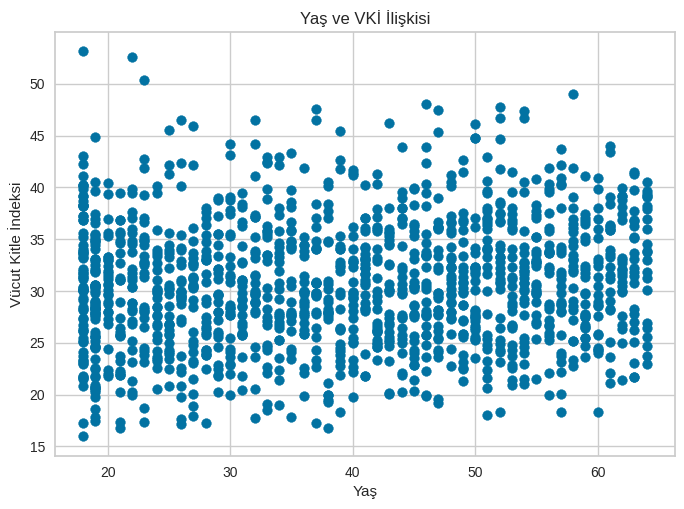

In [15]:
plt.figure()  # Yeni bir grafik figürü oluştur

#Yaş ve VKİ (Vücut Kitle İndeksi) arasındaki ilişkiyi gösteren saçılım grafiği (scatter plot) çiz.
plt.scatter(insurance_df["yas"], insurance_df["vki"])
      # - 'insurance_df["yas"]' → X ekseni için yaş verileri.
      # - 'insurance_df["vki"]' → Y ekseni için vücut kitle indeksi (VKİ) verileri.
      # - 'plt.scatter()' → Her bir veri noktasını bir nokta olarak çizer (korelasyon olup olmadığını anlamak için kullanılır).

plt.xlabel("Yaş")                  # X ekseni etiketini belirle (Yaş bilgisi)
plt.ylabel("Vücut Kitle İndeksi")  # Y ekseni etiketini belirle (VKİ bilgisi)
plt.title("Yaş ve VKİ İlişkisi")   # Grafiğe başlık ekle
plt.show()


**Örnek 2:** Yaş ve ödeme miktarı (Sigara Durumuna Göre)

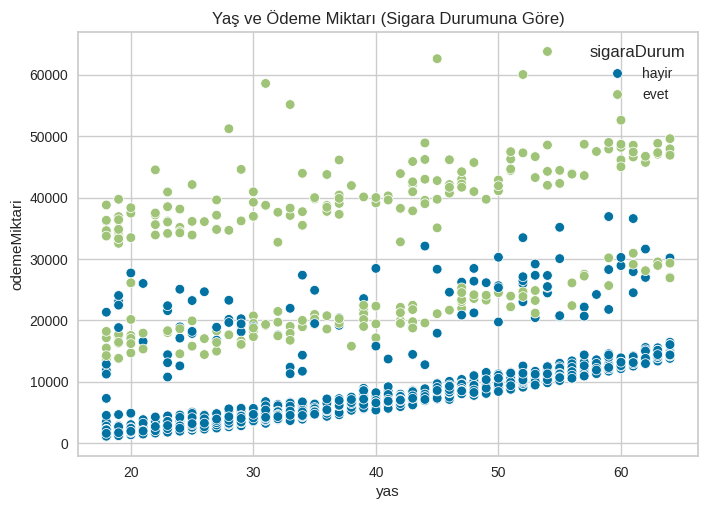

In [16]:
plt.figure()  # Yeni bir grafik figürü oluştur

# Yaş ve ödeme miktarı arasındaki ilişkiyi gösteren saçılım grafiği çiz (Seaborn kullanarak).
sns.scatterplot(x="yas", y="odemeMiktari", hue="sigaraDurum", data=insurance_df)
      # - 'x="yas"' → X eksenine yaş sütunu yerleştirilir.
      # - 'y="odemeMiktari"' → Y eksenine ödeme miktarı sütunu yerleştirilir.
      # - 'hue="sigaraDurum"' → Sigara içme durumuna göre noktaların rengi belirlenir (Sigara içenler ve içmeyenler farklı renklerde olur).
      # - 'data=insurance_df' → Verinin hangi veri çerçevesinden alınacağını belirtir.

plt.title("Yaş ve Ödeme Miktarı (Sigara Durumuna Göre)")
plt.show()


**Örnek 3:** Seçili müşterilerin Yaş ve ödeme **miktarı**

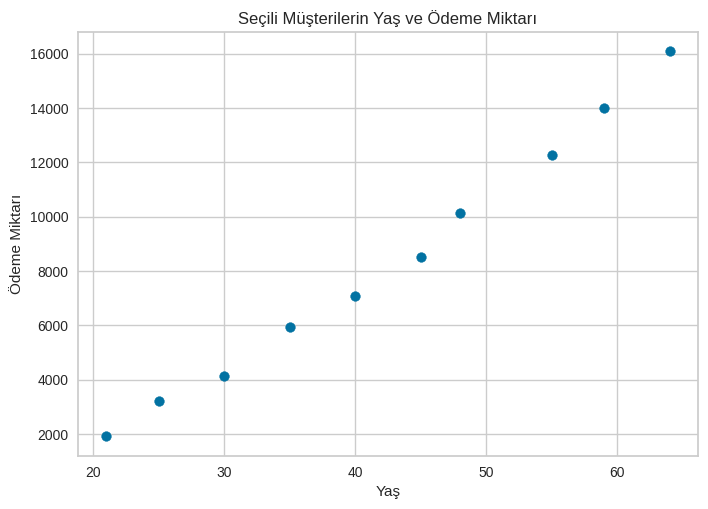

In [17]:
# Seçili müşterilerin indeks numaralarını içeren liste oluştur (Müşteri ID gibi düşünülebilir).
secim = [1072, 548, 1032, 437, 154, 653, 645, 862, 25, 603]

# Seçilen indekslerin veri çerçevesinin sınırlarını aşmadığından emin olmak için filtreleme yap
secim = [i for i in secim if i < len(insurance_df)]
        # - 'if i < len(insurance_df)' → Eğer indeks değeri veri çerçevesindeki toplam satır sayısını aşarsa listeden çıkarılır.
        # - Bu işlem, "IndexError" hatasını önlemek için yapılır.

# Seçili müşterilerin yaş ve ödeme miktarı bilgilerini içeren alt veri kümesi oluştur.
altkume = insurance_df.iloc[secim][["yas", "odemeMiktari"]]
        # - 'insurance_df.iloc[secim]' → Seçili indekslere göre satırları alır.
        # - '[["yas", "odemeMiktari"]]' → Sadece "yaş" ve "ödeme miktarı" sütunlarını seçer.

plt.figure()  # Yeni bir grafik figürü oluştur

# Seçili müşterilerin yaş ve ödeme miktarı arasındaki ilişkiyi gösteren saçılım grafiği çiz.
plt.scatter(altkume["yas"], altkume["odemeMiktari"])
        # - 'altkume["yas"]' → X ekseni için yaş verileri.
        # - 'altkume["odemeMiktari"]' → Y ekseni için ödeme miktarları.
        # - 'plt.scatter()' → Her müşteri için bir nokta olarak veriyi görselleştirir.

plt.xlabel("Yaş")
plt.ylabel("Ödeme Miktarı")
plt.title("Seçili Müşterilerin Yaş ve Ödeme Miktarı")
plt.show()


#### **1.4.5 Histogram**

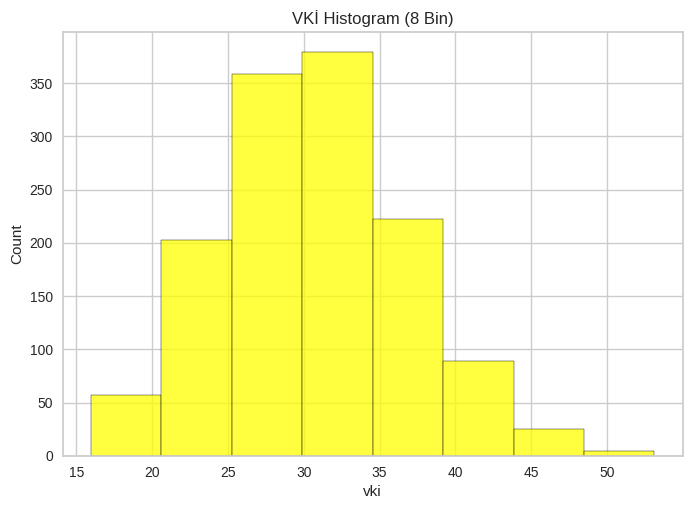

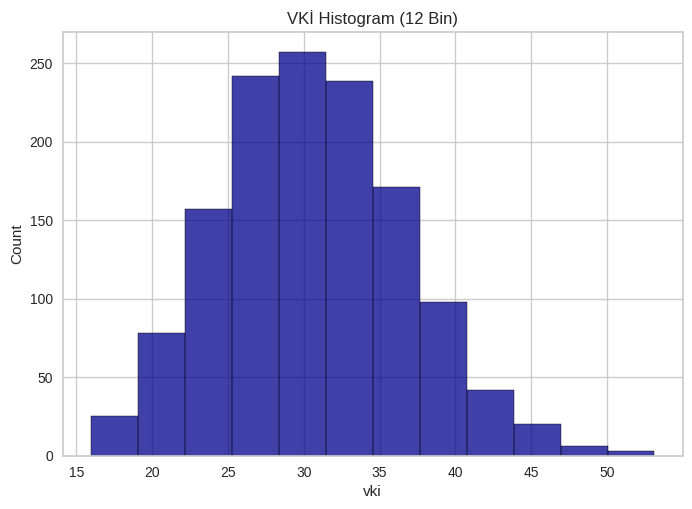

VKİ için describe:
count    1338.000000
mean       30.663397
std         6.098187
min        15.960000
25%        26.296250
50%        30.400000
75%        34.693750
max        53.130000
Name: vki, dtype: float64


In [18]:
plt.figure()
# VKİ dağılımını gösteren histogram (8 bin)
sns.histplot(data=insurance_df, x="vki", color="yellow", bins=8)
        # - 'data=insurance_df' → Veriyi seçer.
        # - 'x="vki"'           → X ekseninde VKİ değerleri kullanılır.
        # - 'color="yellow"'    → Histogram sarı renkte çizilir.
        # - 'bins=8'            → 8 aralıklı bin (sütun) oluşturur.

plt.title("VKİ Histogram (8 Bin)")
plt.show()


plt.figure()
# VKİ dağılımını gösteren histogram (12 bin)
sns.histplot(data=insurance_df, x="vki", color="darkblue", bins=12)
        # - 'color="darkblue"'  → Histogram koyu mavi renkte çizilir.
        # - 'bins=12'           → 12 aralıklı bin (sütun) oluşturur.

plt.title("VKİ Histogram (12 Bin)")
plt.show()


# VKİ değişkeninin tanımlayıcı istatistiklerini ekrana yazdır
print("VKİ için describe:")
print(insurance_df["vki"].describe())
        # - 'describe()'        → Ortalama, min, max, standart sapma gibi istatistikleri gösterir.


